# This Notebook aims at providing code and functions to load the CF datasets, as well as gaining information about them.

In [10]:
#Import all necessary packages
import numpy as np
import scipy.io as sio
import pandas as pd
import random
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import deque
import matplotlib.pyplot as plt


#How many training/testing CF events are available in the datasets ?

import scipy.io as sio

train = sio.loadmat('trainSet.mat')['calibrationData']
test = sio.loadmat('testSet.mat')['validationData']
trainNum = train.shape[0] #Number of training CF events, i.e. drivers. 
testNum = test.shape[0]  #Number of testing events.
print("Number of training CF trajectories:", trainNum)
print("Number of testing CF trajectories:", testNum)

Number of training CF trajectories: 938
Number of testing CF trajectories: 403


In [11]:
#Each element (cell or matrix) in the trainSet.mat and testSet.mat describes a car-following event (i.e. a trajectory
#associated with a specific driver). 
#Then, for each event (matrix), the columns are spacing, following vehicle speed, relative speed, 
#and leading vehicle speed. Events may have different durations (starting from 15 sec).
#Each row of a selected CF event refers to the state at a precise time step (0.1 sec).

#These raw NGSIM datasets (trainSet.mat and testSet.mat) were taken from the open source code provided by the authors 
#of the paper "Safe, efficient, and comfortable velocity control based on reinforcement learning for autonomous driving".
#Here is the link of their GitHub: https://github.com/MeixinZhu/Velocity_control.

#The following function aims at loading the training and testing datasets.
#Then loading the dataframe associated with the car following id.
#This function may then be used as a training (X_train, y_train) and testing list
#(X_test, y_test) provider for a model to use (for the neural networks models for instance). 

def data_loader(car_fol_id, car_fol_id2, SEQ, SEQ_LEN, plot, normalize):
    
    #car_fol_id -> id of the training CF event.
    #car_fol_id2 -> id of the testing CF event. 
    #SEQ -> wether to use sequential data or not (True of False). i.e wether to take into consideration a certain
    #amount of previous time steps.
    #SEQ_LEN -> the length of the sequential data used. 
    #plot -> wether to plot the testing and training trajectories selected (True or False).
    #normalize -> wether to normalize the training and testing datasets (True or False).
    
    #Load training and testing datasets. 
    train = sio.loadmat('trainSet.mat')['calibrationData']
    test = sio.loadmat('testSet.mat')['validationData']
    trainNum = train.shape[0] #Number of training CF events, i.e. drivers/trajectories. 
    testNum = test.shape[0]  #Number of testing events.
    
    #Training data
    data = train[car_fol_id, 0] #0 is the only choice cause there is only 1 column. 
    
    #Testing data
    data_test = test[car_fol_id2, 0]
    
    #Space, Speed, RelativeSpeed and Leading Speed associated with this CF event:TRAINING.
    SpaceData = data[:, 0] 
    SpeedData = data[:, 1]
    RelativeSpeedData = data[:,2]
    LeaderSpeed = data[:,3]
    
    #Space, Speed, RelativeSpeed and Leading Speed associated with this CF event:TESTING.
    SpaceData_test = data_test[:, 0] 
    SpeedData_test = data_test[:, 1]
    RelativeSpeedData_test = data_test[:,2]
    LeaderSpeed_test = data_test[:,3]
    
    ################################ TRAINING DATASET ##########################################
    #Event duration in terms of number of time steps.
    time_span = data.shape[0]
    ctime = [i for i in range(time_span)] #Column of times.

    df = pd.DataFrame(data)
    df["time"] = ctime
    df.set_index("time", inplace = True)
    df.rename(columns = {0 : "Space", 1 : "Speed", 2 : "Relative Speed", 3 : "Leader Speed"}, inplace = True)
    df_all = df
    df = df.drop("Leader Speed", 1) #The leader speed is dropped from this dataset as it is a linear combination 
    #of two other features (Speed and Relative Speed).

    #The features are defined, now we need to add the acceleration, ie the label at each time-step. 
    acceleration = np.zeros(time_span)
    for i in range(time_span-2):
        acceleration[i] = (SpeedData[i+1]-SpeedData[i])/0.1 #Derived from kinetic mass model formula.
    acceleration[time_span-1] = acceleration[time_span-2] #The last two values are the same (subject to change).

    df["acceleration"] = acceleration
    
    #Let's drop the last row to get rid of the last same two values. 
    df = df.drop(len(df.index)-1, 0)
    
    ################################ TESTING DATASET ##########################################
    #Event duration in terms of number of time steps.
    time_span_test = data_test.shape[0]
    ctime_test = [i for i in range(time_span_test)]

    #DataFrame conversion and presentation.
    df_test= pd.DataFrame(data_test)
    df_test["time"] = ctime_test
    df_test.set_index("time", inplace = True)
    df_test.rename(columns = {0 : "Space", 1 : "Speed", 2 : "Relative Speed", 3 : "Leader Speed"}, inplace = True)
    df_test = df_test.drop("Leader Speed", 1)

    #We have our features, now we need to add the acceleration, ie the label at each step. 
    acceleration_test = np.zeros(time_span_test)
    for i in range(time_span_test-2):
        acceleration_test[i] = (SpeedData_test[i+1]-SpeedData_test[i])/0.1 #Derived from kinetic mass model formula.
    acceleration_test[time_span_test-1] = acceleration_test[time_span_test-2] #The last two values are the same (subject to change).

    df_test["acceleration"] = acceleration_test
    
    #Let's drop the last row to get rid of the last same two values. 
    df_test = df_test.drop(len(df_test.index)-1, 0)
    
    ################################# Plotting (x, t) ##############################################
    #Plotting of the selected car following trajectories if required.
    if plot == True:
        t = np.array(df.index)
        t_test = np.array(df_test.index)

        def build_x(df):
            x = [0.0]
            for i in range(1, len(np.array(df.index))):
                v_i = df["Speed"].values[i-1]
                x.append(x[i-1] + v_i*0.1)
            return x

        x = build_x(df)
        x_test = build_x(df_test)
        
        plt.plot(x,t, "blue") #Training curve is blue.
        plt.plot(x_test, t_test, "red") #Testing curve is red. 
        plt.xlabel("Time") 
        plt.ylabel("Space")
        plt.axis('tight')
        plt.show()
        
    ######################## Building of X_train, y_train, X_test and y_test #########################
    #Now that the training and testing dataframe are created, let's build (X,y) training and testing 
    #subdatasets. 
    
    #In this projects' modeling approach, X is the state (Space, Speed, and Relative Speed); while 
    #y is the action to predict (acceleration).
    
    #In the case of NON-SEQUENTIAL desired data. 
    def build_sets(df, df_test, normalize):
    
        X_train, y_train, X_test, y_test = [], [], [], []
        
        #Feature scaling (normalization) if required.
        if normalize == True:
            for c in df.columns:
                if c == "Space":
                    scaler = MinMaxScaler()
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)
                if c == "Speed":
                    scaler = MinMaxScaler()
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)
                if c == "Relative Speed":
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)
                if c == "acceleration":  
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)

            for c in df_test.columns:
                if c == "Space":
                    scaler = MinMaxScaler()
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)
                if c == "Speed":
                    scaler = MinMaxScaler()
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)
                if c == "Relative Speed":
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)
                if c == "acceleration":  
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)

        #Drop all remaining Na's if there are any left.
        df.dropna(inplace = True)
        df_test.dropna(inplace = True) 

        #Building of training sets.
        sequential_data = []  #It is called sequential data but only a single previous time step 
        #will be taken into account.

        for i in df.values:
            sequential_data.append([[n for n in i[:-1]], i[-1]])

        for seq, target in sequential_data:
            X_train.append(seq)
            y_train.append(target)

        #Building of testing sets.
        sequential_data = []

        for j in df_test.values:
            sequential_data.append([[n for n in j[:-1]], j[-1]])

        for seq, target in sequential_data:
            X_test.append(seq)
            y_test.append(target)

        return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    
    #In the case of SEQUENTIAL desired data.
    def build_sets_seq(df, df_test, SEQ_LEN, normalize):

        X_train, y_train, X_test, y_test = [], [], [], []
        
        if normalize == True:
            for c in df.columns:
                if c == "Space":
                    scaler = MinMaxScaler()
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)
                if c == "Speed":
                    scaler = MinMaxScaler()
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)
                if c == "Relative Speed":
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)
                if c == "acceleration":  
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
                    df.dropna(inplace = True)

            for c in df_test.columns:
                if c == "Space":
                    scaler = MinMaxScaler()
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)
                if c == "Speed":
                    scaler = MinMaxScaler()
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)
                if c == "Relative Speed":
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)
                if c == "acceleration":  
                    scaler = MinMaxScaler(feature_range = (-1.0, 1.0))
                    df_test[c] = scaler.fit_transform(df_test[c].values.reshape(-1,1))
                    df_test.dropna(inplace = True)
        
        #Drop all remaining Na's if there are any left.
        df.dropna(inplace = True) 
        df_test.dropna(inplace = True) 

        #Building of training sets.
        sequential_data = [] 
        prev_moments = deque(maxlen = SEQ_LEN) #Reccurent datasets: SEQ_LEN observations for 1 action. 

        for i in df.values:
            prev_moments.append([n for n in i[:-1]])
            if len(prev_moments) == SEQ_LEN:
                sequential_data.append([np.array(prev_moments), i[-1]])

        for seq, target in sequential_data:
            X_train.append(seq)
            y_train.append(target)

        #Building of testing sets.
        sequential_data = []
        prev_moments = deque(maxlen = SEQ_LEN)

        for j in df_test.values:
            prev_moments.append([n for n in j[:-1]])
            if len(prev_moments) == SEQ_LEN:
                sequential_data.append([np.array(prev_moments), j[-1]])

        for seq, target in sequential_data:
            X_test.append(seq)
            y_test.append(target)

        return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), sequential_data

    
    #Effective building:
    
    if SEQ == True:
        
        X_train, y_train, X_test, y_test, sequential_data = build_sets_seq(df, df_test, SEQ_LEN, normalize)
        
        return X_train, y_train, X_test, y_test, df, df_test, sequential_data, LeaderSpeed 
        #In this case the sequential dataset is returned in addition. 
    
    else:
        X_train, y_train, X_test, y_test = build_sets(df, df_test, normalize) 
    
    return X_train, y_train, X_test, y_test, df, df_test, LeaderSpeed

In [28]:
#The following function aims at gaining statistical information about the drivers' acceleration. 

def acceleration_statistics(): 
    
    #Load training and testing datasets. 
    train = sio.loadmat('trainSet.mat')['calibrationData']
    test = sio.loadmat('testSet.mat')['validationData']
    trainNum = train.shape[0] #Number of training CF events, i.e. drivers. 
    testNum = test.shape[0]  #Number of testing events.
    
    data_accel = np.array([0.0])
    data_accel_test = np.array([0.0])
    
    bad = 0 #"Bad" or "unrealistic" acceleration count in the training dataset. 
    bad_l = []
    
    bad_test = 0 #Same for the testing dataset.
    bad_l_test = []

    for car_fol_id in range(1, trainNum): #TRAINING.
        
        #Training data
        data = train[car_fol_id, 0] 
        
        #Space, Speed, RelativeSpeed and Leading Speed associated with this CF event.
        SpaceData = data[:, 0] 
        SpeedData = data[:, 1]
        RelativeSpeedData = data[:,2]
        LeaderSpeed = data[:,3]
        
        #Event duration in terms of number of time steps.
        time_span = data.shape[0]
        ctime = [i for i in range(time_span)]

        #DataFrame conversion and presentation.
        df = pd.DataFrame(data)
        df["time"] = ctime
        df.set_index("time", inplace = True)
        df.rename(columns = {0 : "Space", 1 : "Speed", 2 : "Relative Speed", 3 : "Leader Speed"}, inplace = True)
        df_all = df
        df = df.drop("Leader Speed", 1)

        #The features are defined, now let's add the acceleration, ie the label at each time-step. 
        acceleration = np.zeros(time_span)
        for i in range(time_span-2):
            acceleration[i] = (SpeedData[i+1]-SpeedData[i])/0.1  #Derived from kinetic mass model formula.
            if acceleration[i] > 3.0 or acceleration[i] < -4.0: #Tell wether or not it is an acceptable acceleration. 
                bad = bad + 1 
                bad_l.append(car_fol_id)
                break
                
        acceleration[time_span-1] = acceleration[time_span-2] 
        df["acceleration"] = acceleration
        
        data_accel = np.concatenate((data_accel, acceleration))
        
        #Let's drop the last row to get rid of the last same two values. 
        df = df.drop(len(df.index)-1, 0)

        
    for car_fol_id2 in range(1, testNum): #TESTING
        
        #Training data
        data_test = test[car_fol_id2, 0]
        
        #Space, Speed, RelativeSpeed and Leading Speed associated with this CF event.
        SpaceData_test = data_test[:, 0] 
        SpeedData_test = data_test[:, 1]
        RelativeSpeedData_test = data_test[:,2]
        LeaderSpeed_test = data_test[:,3]
        
        #Event duration in terms of number of time steps.
        time_span_test = data_test.shape[0]
        ctime_test = [i for i in range(time_span_test)]

        #DataFrame conversion and presentation.
        df_test= pd.DataFrame(data_test)
        df_test["time"] = ctime_test
        df_test.set_index("time", inplace = True)
        df_test.rename(columns = {0 : "Space", 1 : "Speed", 2 : "Relative Speed", 3 : "Leader Speed"}, inplace = True)
        df_test = df_test.drop("Leader Speed", 1)

        #The features are defined, now let's add the acceleration, ie the label at each time-step.  
        acceleration_test = np.zeros(time_span_test)
        for i in range(time_span_test-2):
            acceleration_test[i] = (SpeedData_test[i+1]-SpeedData_test[i])/0.1 #Derived from kinetic mass model formula.
            if acceleration_test[i] > 3.0 or acceleration_test[i] < -4.0: #Tell wether or not it is an acceptable acceleration. 
                bad_test = bad_test + 1 
                bad_l_test.append(car_fol_id)
                break
                
        acceleration_test[time_span_test-1] = acceleration_test[time_span_test-2]

        df_test["acceleration"] = acceleration_test
        
        data_accel_test = np.concatenate((data_accel_test, acceleration_test))

        #Let's drop the last row to get rid of the last same two values. 
        df_test = df_test.drop(len(df_test.index)-1, 0)

    df_accel = pd.DataFrame(data_accel)
    df_accel_test = pd.DataFrame(data_accel_test)
    
    df_accel = df_accel.drop(len(df.index)-1, 0)
    df_accel = df_accel.drop(0, 0)
    
    df_accel_test  = df_accel_test.drop(len(df.index)-1, 0)
    df_accel_test  = df_accel_test.drop(0, 0)
    
    return df_accel, df_accel_test, bad, bad_l, bad_test, bad_l_test

In [29]:
df_accel, df_accel_test, bad, bad_l, bad_test, bad_l_test = acceleration_statistics() 

In [22]:
print(bad)
print(bad_test)

#Out of 938 and 403 training and testing trajs, i.e.,  these can be considered acceptable.

51
22


In [31]:
df_accel.describe().rename(columns = {0 : "Acceleration"}).drop("count")

,Acceleration
mean,0.018237
std,0.834587
min,-4.801514
25%,-0.305592
50%,0.000000
75%,0.345095
max,7.459279


In [33]:
df_accel_test.describe().rename(columns = {0 : "Acceleration"}).drop("count")

,Acceleration
mean,0.011608
std,0.838080
min,-5.002987
25%,-0.312801
50%,0.000000
75%,0.345201
max,4.390796


In [8]:
#The following function aims at gaining statistical information about the drivers' state (space, speed, and relative speed). 

def datasets_statistics(): 
    
    #Load training and testing datasets. 
    train = sio.loadmat('trainSet.mat')['calibrationData']
    test = sio.loadmat('testSet.mat')['validationData']
    trainNum = train.shape[0] #Number of training CF events, i.e. drivers. 
    testNum = test.shape[0]  #Number of testing events.
    
    data = train[1,0]
    for car_fol_id in range(2, trainNum):
        #Training data
        data_aux = train[car_fol_id, 0] #0 is the only choice cause there is only 1 column. 
        data = np.concatenate((data, data_aux))
        
    data_test = test[1,0]
    for car_fol_id2 in range(2, testNum):
        #Testing data
        data_aux = test[car_fol_id2, 0] #0 is the only choice cause there is only 1 column. 
        data_test = np.concatenate((data_test, data_aux))

    #Space, Speed, RelativeSpeed and Leading Speed associated with this CF event:TRAINING.
    SpaceData = data[:, 0] 
    SpeedData = data[:, 1]
    RelativeSpeedData = data[:,2]
    LeaderSpeed = data[:,3]

    #Space, Speed, RelativeSpeed and Leading Speed associated with this CF event:TESTING.
    SpaceData_test = data_test[:, 0] 
    SpeedData_test = data_test[:, 1]
    RelativeSpeedData_test = data_test[:,2]
    LeaderSpeed_test = data_test[:,3]

        ################################ TRAINING DATASET ##########################################
        #Event duration in terms of number of time steps.
    time_span = data.shape[0]
    ctime = [i for i in range(time_span)]

        #DataFrame conversion and presentation.
    df = pd.DataFrame(data)
    df["time"] = ctime
    df.set_index("time", inplace = True)
    df.rename(columns = {0 : "Space", 1 : "Speed", 2 : "Relative Speed", 3 : "Leader Speed"}, inplace = True)
    df_all = df
    df = df.drop("Leader Speed", 1)

        ################################ TESTING DATASET ##########################################
        #Event duration in terms of number of time steps.
    time_span_test = data_test.shape[0]
    ctime_test = [i for i in range(time_span_test)]

        #DataFrame conversion and presentation.
    df_test= pd.DataFrame(data_test)
    df_test["time"] = ctime_test
    df_test.set_index("time", inplace = True)
    df_test.rename(columns = {0 : "Space", 1 : "Speed", 2 : "Relative Speed", 3 : "Leader Speed"}, inplace = True)
    df_test = df_test.drop("Leader Speed", 1)
    
    return df, df_test

In [9]:
df, df_test = datasets_statistics()

In [17]:
df_test.describe().drop("count")

,Space,Speed,Relative Speed
mean,13.785446,8.640215,0.020580
std,7.218130,2.668813,0.943893
min,0.072158,5.000061,-2.499982
25%,9.048518,7.021192,-0.604671
50%,12.108695,8.073000,0.013390
75%,16.560402,9.326501,0.654858
max,61.057003,25.522141,2.499409


In [18]:
df.describe().drop("count")

,Space,Speed,Relative Speed
mean,14.591456,8.760555,0.010019
std,7.422259,2.734282,0.948134
min,0.472699,5.000101,-2.499750
25%,9.556573,7.007532,-0.616035
50%,13.217350,8.105644,0.005349
75%,18.047011,9.545164,0.637405
max,87.825663,24.958261,2.499421


In [93]:
#The following function aims at gaining information about trajectories' TTC (Time To Collision) 
#and to split the drivers into groups depending on their TTC (aggressive, timid or neutral).

#Because these groups are used in the testing phase of the models, only the testing dataset is used.

def driver_classifier_TTC(): 
    
    #Load testing dataset. 
    test = sio.loadmat('testSet.mat')['validationData'] 
    testNum = test.shape[0]  #Number of testing events, i.e. drivers. 
        
    drivers_TTC = [] #List of [mean_TTC, car_fol_id] where mean_TTC is a specific driver's average TTC
    #and car_fol_id is its associated CF id. 
    
    drivers_perc_TTC = []
    
    df_TTC_list = [] #DataFrame of TTCs for all drivers. 
    
    for car_fol_id2 in range(0, testNum):
        
        #Testing data associated with the car following id. 
        data_test = test[car_fol_id2, 0] 

        #Space, Speed, RelativeSpeed and Leading Speed associated with this CF event:TESTING.
        SpaceData_test = data_test[:, 0] 
        SpeedData_test = data_test[:, 1]
        RelativeSpeedData_test = data_test[:,2]
        LeaderSpeed_test = data_test[:,3]

        #Event duration in terms of number of time steps.
        time_span_test = data_test.shape[0]
        ctime_test = [i for i in range(time_span_test)]

        #DataFrame conversion and presentation.
        df_test= pd.DataFrame(data_test)
        df_test["time"] = ctime_test
        df_test.set_index("time", inplace = True)
        df_test.rename(columns = {0 : "Space", 1 : "Speed", 2 : "Relative Speed", 3 : "Leader Speed"}, inplace = True)
        df_test = df_test.drop("Leader Speed", 1)

        #Computation of the TTC at each time step of the trajectory. 
        TTC_test = np.zeros(time_span_test)
        aggressive_count = 0
        timid_count = 0
        
        for i in range(time_span_test):
            
            ttc = -SpaceData_test[i]/RelativeSpeedData_test[i]
            
            #The TTC can reach very high values if the relative speed is very close to 0 (which happens sometimes).
            #However such high values are not interesting for our TTC feature (fTTC) as they 
            #refer to a very safe driving condition at a certain time step.
            #Therefore the choice was made to bound it between -2 and 50 to make it more convenient for the plotting.   
            #This bound choice is the same as in "Safe, efficient, and comfortable velocity control 
            #based on reinforcement learning for autonomous driving".
            
            #if ttc > 50:
                #ttc = 50
                
            #if ttc < -2.0:
                #ttc = -2.0
                
            if ttc > 0 and ttc < 8.001:
                aggressive_count += 1
                
            #if ttc > 330:
                #timid_count += 1
                
            TTC_test[i] = ttc
        
        aggressive_perc = (aggressive_count / time_span_test)*100
        timid_perc = (timid_count / time_span_test)*100

        df_test["TTC"] = TTC_test
    
        df_TTC_list.append(df_test)
        
        ttc_mean = np.mean(TTC_test)
            
        drivers_TTC.append([ttc_mean, car_fol_id2])
        
        drivers_perc_TTC.append([aggressive_perc, timid_perc, car_fol_id2])
        
    #Function to effectively classify drivers. 
    def driver_classifier_aux(drivers_perc_TTC):
    
        aggressive_drivers = []
        neutral_drivers = []
        timid_drivers = []
        
        for [aggressive_perc, timid_perc, ind] in drivers_perc_TTC:
            
            if aggressive_perc >= 10:
                aggressive_drivers.append(ind)

            if aggressive_perc == 0:
                timid_drivers.append(ind)

            elif (aggressive_perc > 0 and aggressive_perc < 10):
                neutral_drivers.append(ind)

        return aggressive_drivers, neutral_drivers, timid_drivers
    
    aggressive_drivers, neutral_drivers, timid_drivers = driver_classifier_aux(drivers_perc_TTC)
    
    timid_TTC = [x for x in drivers_TTC if (x[1] in timid_drivers and x[0] > 0)]
    timid_TTC_sorted = np.sort(timid_TTC, axis = 0)
    flop3_tim = [timid_TTC_sorted[0],
                timid_TTC_sorted[1]]
    
    aggressive_perc_TTC = [x for x in drivers_perc_TTC if x[2] in aggressive_drivers]
    aggressive_perc_TTC_sorted = np.sort(aggressive_perc_TTC, axis = 0)
    flop3_ag = [aggressive_perc_TTC_sorted[0],
               aggressive_perc_TTC_sorted[1]]
    
    return df_TTC_list, drivers_TTC, drivers_perc_TTC, aggressive_drivers, neutral_drivers, timid_drivers, flop3_ag, flop3_tim

In [94]:
df_TTC_list, drivers_TTC, drivers_perc_TTC, aggressive_drivers, neutral_drivers, timid_drivers, flop3_ag, flop3_tim = driver_classifier_TTC()

In [95]:
print("Aggressive drivers IDs:",aggressive_drivers)
print("Timid drivers IDs:", timid_drivers)
print("Neutral drivers IDs", neutral_drivers)
print("Number of aggressive drivers:",len(aggressive_drivers))
print("Number of timid drivers:",len(timid_drivers))
print("Number of neutral drivers:",len(neutral_drivers))

print("Less aggressive drivers with their ag perc", flop3_ag)
print("Less aggressive drivers ID", np.array(flop3_ag, dtype = int)[:,2])
print("Less timid drivers with their mean TTC", flop3_tim)
print("Less timid drivers ID", np.array(flop3_tim, dtype = int)[:,1])

print("Good sum?", len(timid_drivers)+len(aggressive_drivers)+len(neutral_drivers)==403)

Aggressive drivers IDs: [2, 3, 4, 9, 17, 20, 21, 22, 35, 37, 40, 51, 57, 61, 65, 67, 70, 75, 78, 80, 81, 90, 92, 93, 96, 97, 105, 116, 122, 125, 135, 140, 141, 145, 148, 149, 151, 154, 156, 158, 161, 164, 167, 172, 174, 176, 182, 187, 190, 191, 192, 195, 203, 206, 210, 211, 214, 218, 219, 220, 221, 231, 234, 235, 237, 257, 258, 265, 268, 270, 274, 276, 278, 287, 292, 293, 295, 297, 298, 303, 304, 307, 310, 312, 314, 317, 320, 321, 322, 332, 334, 339, 340, 349, 362, 364, 365, 366, 367, 370, 373, 376, 379, 380, 382, 383, 384, 393, 396]
Timid drivers IDs: [10, 14, 18, 24, 26, 28, 29, 30, 34, 39, 41, 44, 46, 47, 48, 49, 52, 68, 74, 76, 84, 85, 87, 89, 99, 101, 103, 106, 107, 110, 111, 114, 119, 121, 128, 132, 136, 142, 144, 147, 150, 155, 157, 159, 162, 166, 168, 169, 181, 185, 188, 189, 193, 197, 198, 199, 202, 207, 208, 217, 224, 230, 233, 239, 242, 247, 249, 250, 252, 254, 255, 261, 264, 277, 279, 281, 283, 285, 288, 290, 294, 301, 302, 305, 306, 308, 313, 319, 327, 336, 343, 345, 348, 

In [14]:
drivers_perc_TTC

[[0.0, 0.0, 0],
 [4.953560371517028, 0.0, 1],
 [0.0, 0.0, 2],
 [4.2105263157894735, 0.0, 3],
 [2.262443438914027, 0.0, 4],
 [0.0, 0.0, 5],
 [0.0, 0.0, 6],
 [0.0, 0.0, 7],
 [0.0, 0.0, 8],
 [2.955665024630542, 0.0, 9],
 [0.0, 0.0, 10],
 [0.0, 0.0, 11],
 [0.0, 0.0, 12],
 [0.0, 0.0, 13],
 [0.0, 0.0, 14],
 [0.0, 0.0, 15],
 [0.0, 0.0, 16],
 [0.0, 0.0, 17],
 [0.0, 0.0, 18],
 [0.0, 0.0, 19],
 [0.0, 0.0, 20],
 [4.240282685512367, 0.0, 21],
 [0.0, 0.0, 22],
 [0.0, 0.0, 23],
 [0.0, 0.0, 24],
 [0.0, 0.0, 25],
 [0.0, 0.0, 26],
 [0.0, 0.0, 27],
 [0.0, 0.0, 28],
 [0.0, 0.0, 29],
 [0.0, 0.0, 30],
 [0.0, 0.0, 31],
 [0.4662004662004662, 0.0, 32],
 [0.0, 0.0, 33],
 [0.0, 0.0, 34],
 [2.8938906752411575, 0.0, 35],
 [0.0, 0.0, 36],
 [0.0, 0.0, 37],
 [0.0, 0.0, 38],
 [0.0, 0.0, 39],
 [0.5555555555555556, 0.0, 40],
 [0.0, 0.0, 41],
 [0.0, 0.0, 42],
 [0.0, 0.0, 43],
 [0.0, 0.0, 44],
 [0.0, 0.0, 45],
 [0.0, 0.0, 46],
 [0.0, 0.0, 47],
 [0.0, 0.0, 48],
 [0.0, 0.0, 49],
 [0.0, 0.0, 50],
 [0.0, 0.0, 51],
 [0.0, 0.0

In [32]:
drivers_TTC

[[17.92374554288849, 0],
 [7.729688079781269, 1],
 [9.67355658843423, 2],
 [7.403071624286933, 3],
 [7.74254992983783, 4],
 [9.63442286713692, 5],
 [5.394700429023253, 6],
 [5.755594017951497, 7],
 [12.43131901002435, 8],
 [12.564087656102247, 9],
 [11.987724399541557, 10],
 [11.297010787230727, 11],
 [14.265063837013134, 12],
 [20.790740868079414, 13],
 [5.489572380473076, 14],
 [17.272940456203813, 15],
 [13.607894955049916, 16],
 [7.910692415774327, 17],
 [16.743512801423854, 18],
 [19.613120948738764, 19],
 [14.806116044730175, 20],
 [4.878512857208253, 21],
 [5.467581442710745, 22],
 [11.587989585018633, 23],
 [20.29419842686301, 24],
 [10.596703367862942, 25],
 [7.203206499195679, 26],
 [9.434107683849103, 27],
 [9.278522817750437, 28],
 [13.026804707549909, 29],
 [16.359540418087985, 30],
 [10.289016942360346, 31],
 [10.843823876642526, 32],
 [14.178377746902365, 33],
 [9.382073243577393, 34],
 [8.456712581491246, 35],
 [6.911158325963924, 36],
 [9.239941419269677, 37],
 [8.8333

Overall average TTC: 20.133849941696827 +/- 283.8839532911821 sec


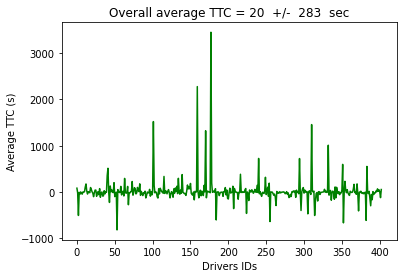

In [54]:
y = np.array(drivers_TTC)

plt.plot(y[:,0], color = "green")

plt.xlabel('Drivers IDs')
plt.ylabel('Average TTC (s)')

x = np.array(drivers_TTC)[:,0]

plt.title("Overall average TTC = "+ "20  "+ "+/-"+ "  283" + "  sec")

print("Overall average TTC:", np.mean(y[:,0]), "+/-", np.std(y[:,0]), "sec")

Overall percentage TTC below 4s: 0.768184326256092 +/- 2.1344992010871686 %


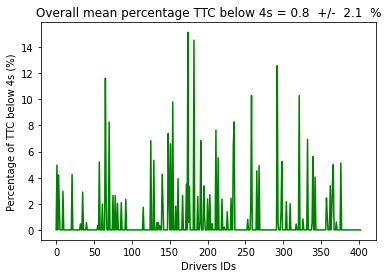

In [68]:
plt.plot(np.array(drivers_perc_TTC)[:,0], color = "green")

plt.xlabel('Drivers IDs')
plt.ylabel('Percentage of TTC below 4s (%)')

x = np.array(drivers_perc_TTC)[:,0]

plt.title("Overall mean percentage TTC below 4s = "+ "0.8  "+ "+/-"+ "  2.1" + "  %")

print("Overall percentage TTC below 4s:", np.mean(x), "+/-", np.std(x), "%")

Overall percentage TTC below 8s: 6.820460293774173 +/- 7.780287568951428 %


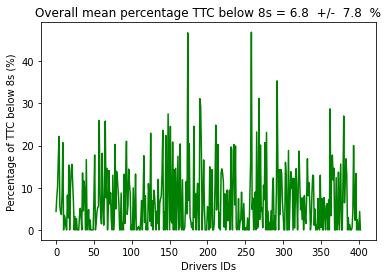

In [92]:
plt.plot(np.array(drivers_perc_TTC)[:,0], color = "green")

plt.xlabel('Drivers IDs')
plt.ylabel('Percentage of TTC below 8s (%)')

x = np.array(drivers_perc_TTC)[:,0]

plt.title("Overall mean percentage TTC below 8s = "+ "6.8  "+ "+/-"+ "  7.8" + "  %")

print("Overall percentage TTC below 8s:", np.mean(x), "+/-", np.std(x), "%")

Overall percentage TTC above 300s: 2.5457452159104137 +/- 2.402236290122372 %


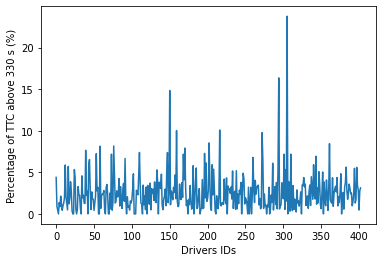

In [88]:
plt.plot(np.array(drivers_perc_TTC)[:,1])

plt.xlabel('Drivers IDs')
plt.ylabel('Percentage of TTC above 330 s (%)')

x = np.array(drivers_perc_TTC)[:,1]
print("Overall percentage TTC above 300s:", np.mean(x), "+/-", np.std(x), "%")

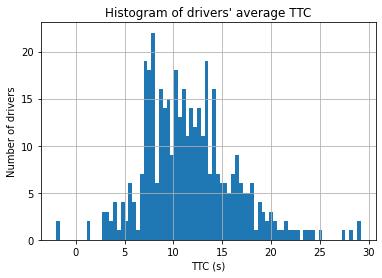

In [36]:
a = plt.hist(np.array(drivers_TTC)[:,0], bins = 80)
plt.xlabel('TTC (s)')
plt.ylabel('Number of drivers')
plt.title("Histogram of drivers' average TTC" )
plt.grid(True)
plt.show()

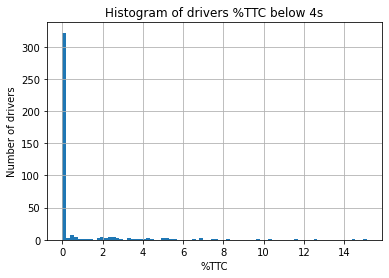

In [39]:
a = plt.hist(np.array(drivers_perc_TTC)[:,0], bins = 80)
plt.xlabel('%TTC')
plt.ylabel('Number of drivers')
plt.title("Histogram of drivers %TTC below 4s" )
plt.grid(True)
plt.show()